In [1]:
import torch
import numpy as np
from idem_net_mnist import IdemNetMnist
from idem_net_celeba import IdemNetCeleba
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random

import numpy as np
from PIL import Image

/Users/je/anaconda3/envs/DL-Idempotant/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/je/anaconda3/envs/DL-Idempotant/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/je/anaconda3/envs/DL-Idempotant/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/je/anaconda3/envs/DL-Idempotant/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/je/anaconda3/envs/DL-Idempotant/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/je/anaconda3/envs/DL-Idempotant/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/je/anaconda3/envs/DL-Idempotant/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Othe

In [2]:
run_id = "celeba20241113-154812"
epoch_num = "_final.pth"

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


checkpoint_path = f"checkpoints/{run_id}/{epoch_num}"
device

device(type='mps')

In [3]:
model = IdemNetCeleba(3)
#model.eval()

state_dict = torch.load(checkpoint_path, weights_only=True, map_location=device)
#state_dict = state_dict["model_state_dict"]

In [4]:
model.load_state_dict(state_dict)
#model.eval()

<All keys matched successfully>

In [5]:
class CelebAWithAttributes(Dataset):
    def __init__(self, data, attr_dict):
        self.data = data
        self.attr_dict = attr_dict

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def get_images_with_attribute(self, attribute, num_samples):
        if attribute not in self.attr_dict:
            raise ValueError(f"Attribute '{attribute}' not found in dataset attributes.")
        
        # Randomly select a specified number of samples with the attribute
        selected_indices = random.sample(self.attr_dict[attribute], min(num_samples, len(self.attr_dict[attribute])))
        return [self.data[i][0] for i in selected_indices]  # Returns images only
    
    def get_images_without_attribute(self, attribute, num_samples):
        if attribute not in self.attr_dict:
            raise ValueError(f"Attribute '{attribute}' not found in dataset attributes.")

        # Randomly select a specified number of samples without the attribute
        selected_indices = random.sample([i for i in range(len(self.data)) if i not in self.attr_dict[attribute]], min(num_samples, len(self.data) - len(self.attr_dict[attribute])))
        return [self.data[i][0] for i in selected_indices]


# load data
def load_CelebA(batch_size=1):
    transform = transforms.Compose([
        transforms.CenterCrop(178),
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    # Load the training dataset with attributes
    training_data = datasets.CelebA(
        root='data/',
        split='train',
        target_type='attr',
        transform=transform,
        download=True
    )

    # Build an attribute dictionary
    attr_dict = {attr: [] for attr in training_data.attr_names}
    for i, (_, attr) in enumerate(training_data):
        for j, has_attr in enumerate(attr):
            if has_attr == 1:
                attr_dict[training_data.attr_names[j]].append(i)

    # Use the custom dataset class with the attribute dictionary
    train_data = CelebAWithAttributes(training_data, attr_dict)
    #test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_data

In [6]:
def plot_generation(inputs, outputs, outputs2, outputs3, num_images=5, show=False):
    """
    Plots input and output image pairs side by side.
    
    Parameters:
    - inputs: Batch of input images, expected shape (batch_size, height, width).
    - outputs: Batch of output images, expected shape (num_applications, batch_size, height, width).
    - num_images: Number of image pairs to display (default is 5).
    """
    # Limit the number of images to the smaller of num_images or batch size
    num_images = min(num_images, len(inputs), len(outputs))
    
    plt.figure(figsize=(8, num_images * 4))
    for i in range(num_images):
        # Plot input image
        plt.subplot(num_images, 4, 2 * i + 1)
        plt.imshow(inputs[i].squeeze().permute(1,2,0).detach().numpy())
        plt.title("With Attr.")
        plt.axis('off')
        
        # Plot output image
        plt.subplot(num_images, 4, 2 * i + 2)
        plt.imshow(outputs[i].squeeze().permute(1,2,0).detach().numpy())
        plt.title("Without Attr.")
        plt.axis('off')

        # Plot output image
        plt.subplot(num_images, 4, 2 * i + 3)
        plt.imshow(outputs2[i].squeeze().permute(1,2,0).detach().numpy())
        plt.title("Image 2")
        plt.axis('off')
        
        # Plot output image
        plt.subplot(num_images, 4, 2 * i + 4)
        plt.imshow(outputs3[i].squeeze().permute(1,2,0).detach().numpy())
        plt.title("Result")
        plt.axis('off')

    plt.tight_layout()
    if show:
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03803479..0.9968018].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046008..0.99441904].


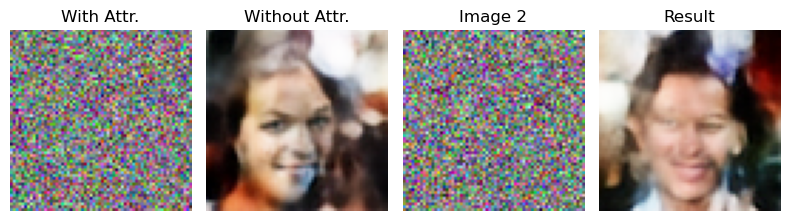

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046008..0.99441904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043196753..0.9918227].


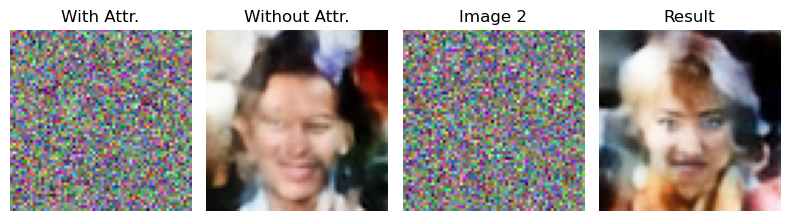

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043196753..0.9918227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037263893..0.99410564].


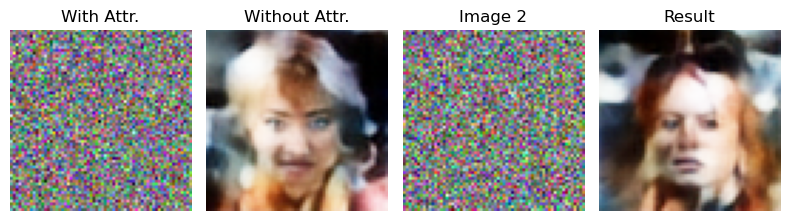

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037263893..0.99410564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06262226..0.9843081].


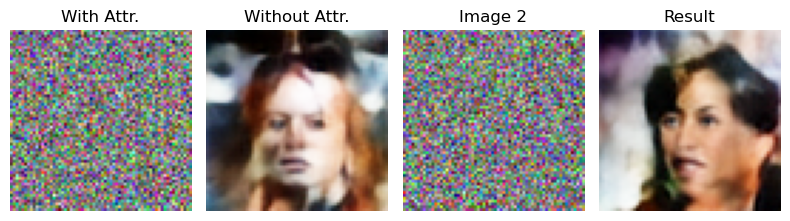

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06262226..0.9843081].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02540518..0.9924972].


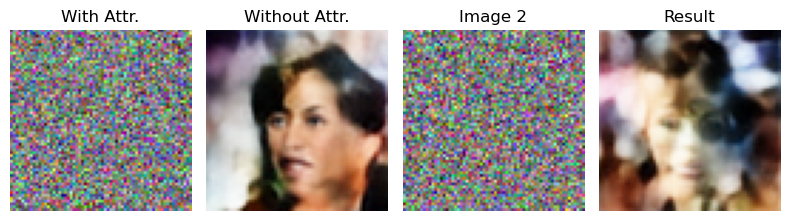

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02540518..0.9924972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022904074..0.9986288].


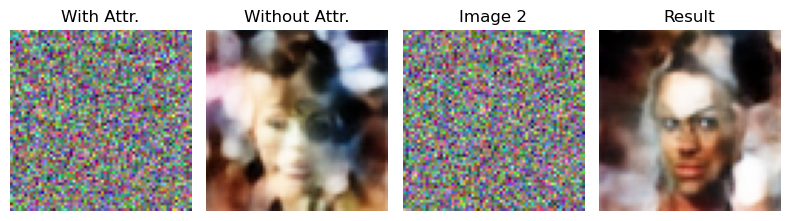

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022904074..0.9986288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041142456..0.9910697].


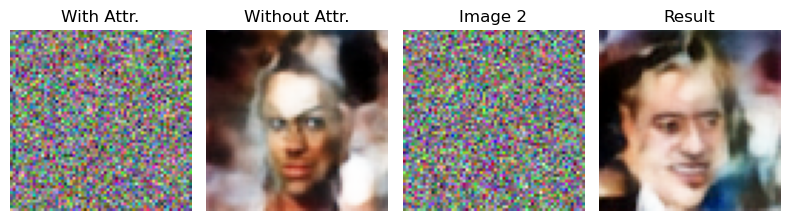

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041142456..0.9910697].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048757922..0.99475807].


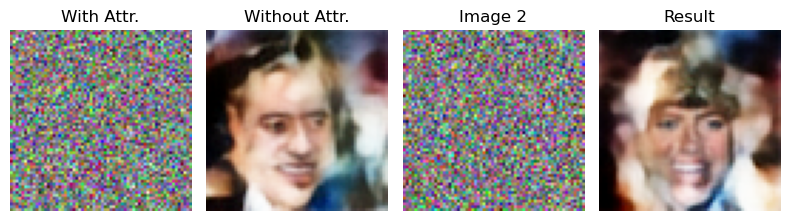

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048757922..0.99475807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035850003..0.9871182].


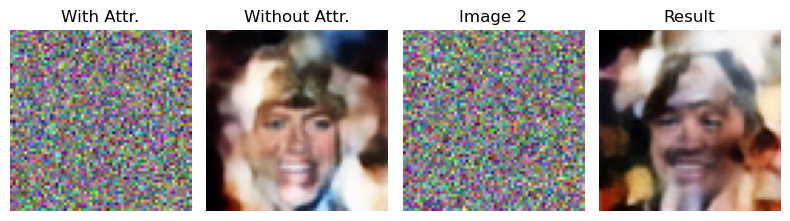

In [26]:
## Generate 200 images to look for ones with glasses

num_noise = 10
#noise = torch.randn(num_noise, 3, 64, 64)/2 + 0.5
noise = torch.normal(0.5, 0.2, size=(num_noise, 3, 64, 64))
noise = torch.clamp(noise, 0, 1)

outputs = torch.zeros(num_noise, 1, 3, 64, 64)

# Generate images with noise
for i in range (num_noise):
    outputs[i] = model(noise[i].unsqueeze(0)).squeeze(0)
    #outputs[i] = torch.clamp(outputs[i], 0, 1)

# visulize the images
for i in range(0, num_noise-1):
    plot_generation(noise[i].unsqueeze(0), outputs[i], noise[i+1].unsqueeze(0), outputs[i+1], num_images=1, show=True)




In [7]:
def mean_of_attribute(data, num_samples = 3, attribute = 'Eyeglasses'):
    
    return torch.stack(data).mean(dim=0)

attribute_zpositive = 'Eyeglasses'

train_data = load_CelebA()

# Get images with and without the attribute
with_attr = train_data.get_images_with_attribute(attribute_zpositive, 3)
without_attr = train_data.get_images_without_attribute(attribute_zpositive, 3)

# Calculate the mean of the images with the attribute
mean_with_attr = mean_of_attribute(with_attr)
mean_without_attr = mean_of_attribute(without_attr)

# Calculate the difference between the means
diff = mean_with_attr / mean_without_attr

# Generate image with diff
f_diff = model(diff.unsqueeze(0))

# Select random image without the attribute
random_img = train_data.get_images_without_attribute(attribute_zpositive, 1)

# Add f_diff to the images without the attribute
edited_img = f_diff + random_img[0]



Files already downloaded and verified


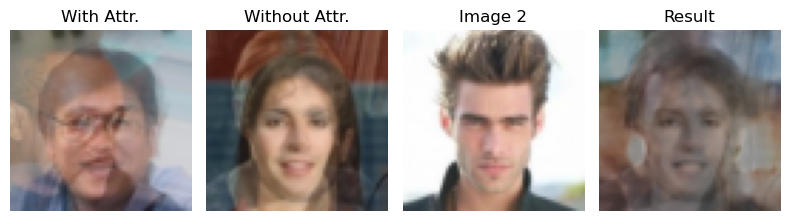

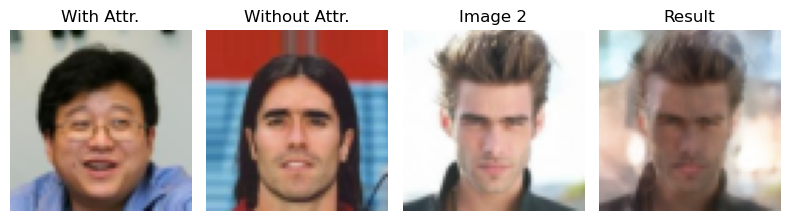

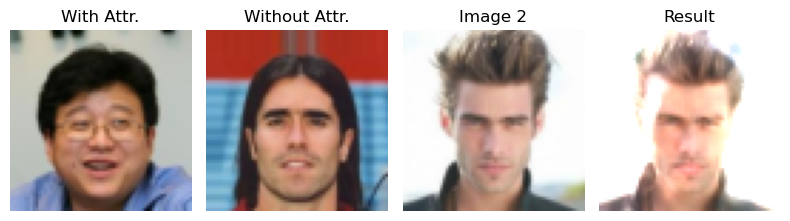

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009285334..0.9977301].


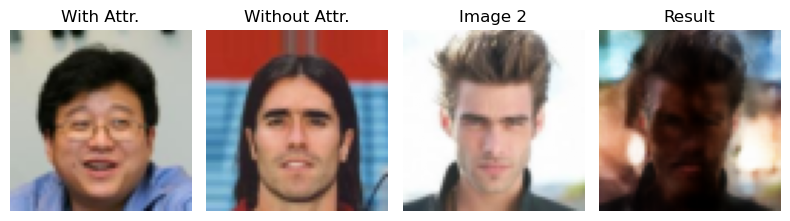

In [8]:
edited_img =  (f_diff + mean_without_attr[0])/2
plot_generation(mean_with_attr.unsqueeze(0), mean_without_attr.unsqueeze(0), random_img, edited_img, num_images=1, show=True)

edited_img = (f_diff + random_img[0])/2
plot_generation(with_attr, without_attr, random_img, edited_img, num_images=1, show=True)

edited_img = torch.clip(f_diff + random_img[0], 0, 1)
plot_generation(with_attr, without_attr, random_img, edited_img, num_images=1, show=True)

edited_img = f_diff * random_img[0]
plot_generation(with_attr, without_attr, random_img, edited_img, num_images=1, show=True)


In [9]:
# Generate random images based on noise with the same shape as the input images
num_noise = 2
noise = torch.randn(num_noise, 3, 64, 64)

# Do interpolation between the first two images
num_interpolations = 30
interpolations = torch.zeros(num_interpolations, 1, 3, 64, 64)
outputs = torch.zeros(num_interpolations, 1, 3, 64, 64)
outputs2 = torch.zeros(num_interpolations, 1, 3, 64, 64)
for i in range(num_interpolations):
    alpha = i / (num_interpolations - 1)
    interpolations[i] = alpha * noise[0] + (1 - alpha) * noise[1]





In [10]:
import os

output_dir = "output_images_latentspace_celeba"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# output for interpolations
for i in range(num_interpolations):
    outputs[i] = model(interpolations[i])
    outputs2[i] = model(outputs[i])
    plot_generation(interpolations[i], outputs[i], outputs2[i], num_images=1)
    # Save plot
    plt.savefig(os.path.join(output_dir, f"interpolation_celeba_{i}.png"))
    plt.close()


TypeError: plot_generation() missing 1 required positional argument: 'outputs3'